In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

📊 Class distribution before SMOTE:
Label_unify
drowsy    7324
alert     1633
Name: count, dtype: int64


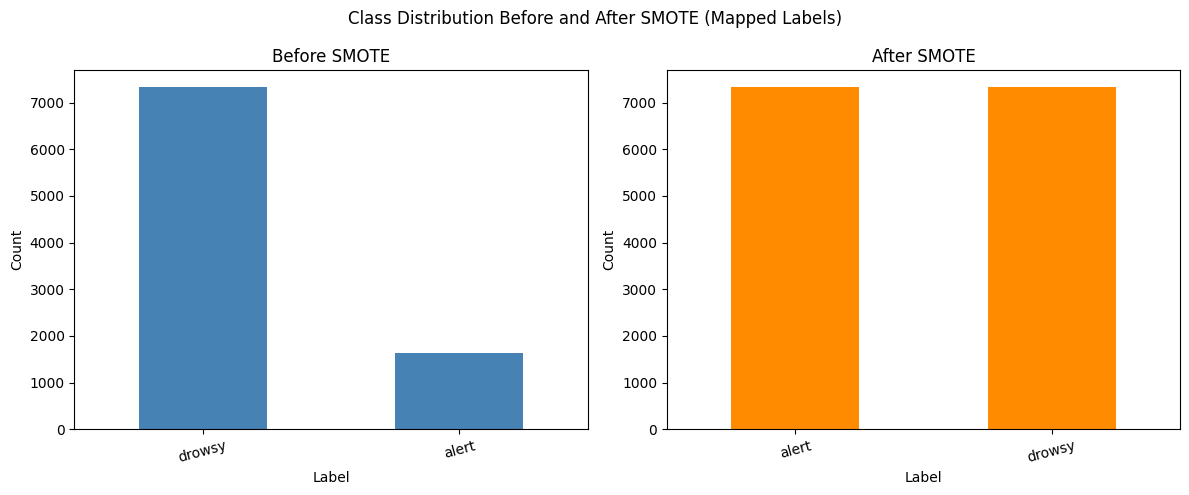

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# === Load original dataset ===
df = pd.read_csv('Classification_Combined_Data/S1_S2_train_catch22.csv')

# === Define label map ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}
df['Label_unify'] = df['Label_unify'].map(label_map)

# === Drop metadata columns ===
feature_cols = [col for col in df.columns if col not in ['ID', 'record_time', 'UNIX', 'Label_unify', 'Label_num']]
X = df[feature_cols].fillna(0)  # <-- Replace NaN with 0 here
y = df['Label_unify']

# === Encode remapped labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Class distribution BEFORE SMOTE ===
print("📊 Class distribution before SMOTE:")
print(y.value_counts())

# === Apply SMOTE ===
smote = SMOTE(random_state=42)
X_sm, y_sm_enc = smote.fit_resample(X, y_enc)
y_sm = le.inverse_transform(y_sm_enc)

# === Combine features + labels ===
X_sm_df = pd.DataFrame(X_sm, columns=feature_cols)
y_sm_df = pd.Series(y_sm, name='Label')
df_sm = pd.concat([y_sm_df, X_sm_df], axis=1)

# === Save oversampled dataset ===
# df_sm.to_csv('Classification_Combined_Data/S1_S2_train_data_c22_SMOTE_mapped.csv', index=False)
# print("\n✅ Mapped + SMOTEd data saved to: S1_S2_train_data_c22_SMOTE_mapped.csv")

# === Plot distributions ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
y.value_counts().plot(kind='bar', ax=ax[0], title='Before SMOTE', color='steelblue')
pd.Series(y_sm).value_counts().plot(kind='bar', ax=ax[1], title='After SMOTE', color='darkorange')

for a in ax:
    a.set_xlabel("Label")
    a.set_ylabel("Count")
    a.tick_params(axis='x', rotation=15)

plt.suptitle("Class Distribution Before and After SMOTE (Mapped Labels)")
plt.tight_layout()
plt.show()

🔍 Original train labels: ['Not Drowsy' 'Slight' 'Moderate' 'Very']
🔍 Original test labels: ['Not Drowsy' 'Slight' 'Moderate' 'Very']
✅ Train rows after mapping: 8957
✅ Test rows after mapping: 2038

📊 Random Forest (Catch22 Features):
              precision    recall  f1-score   support

       alert       0.49      0.07      0.12       535
      drowsy       0.75      0.98      0.85      1503

    accuracy                           0.74      2038
   macro avg       0.62      0.52      0.48      2038
weighted avg       0.68      0.74      0.65      2038

Balanced F1 Score (macro): 0.4805
Balanced F1 Score (weighted): 0.6539
ROC AUC: 0.6624


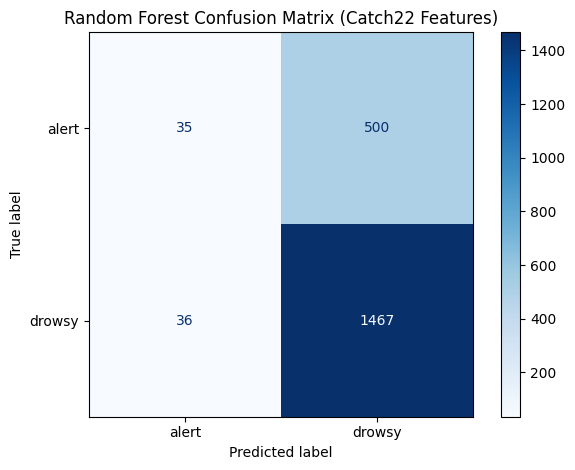

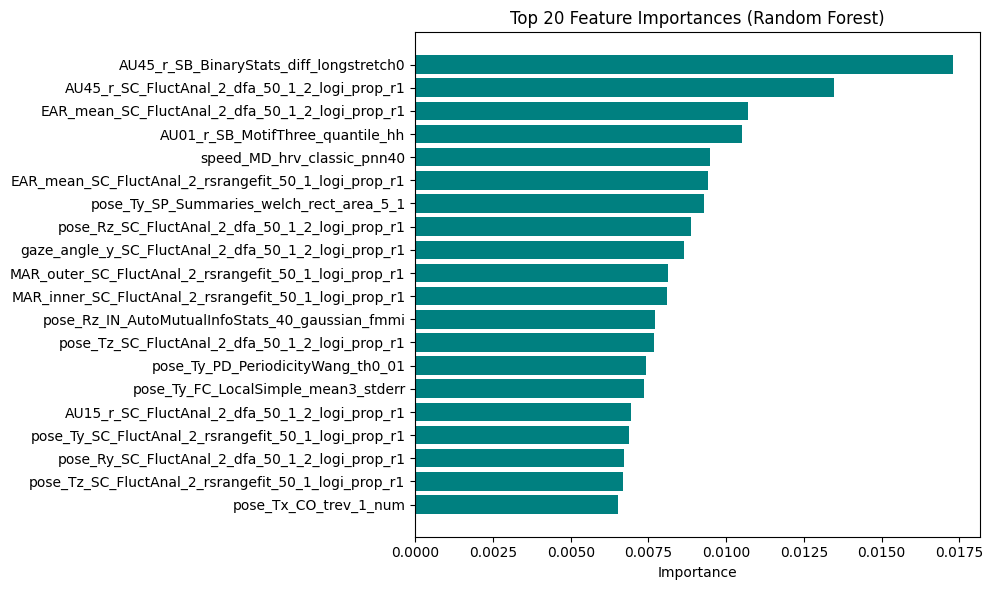

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE

# === FILE PATHS ===
train_path = 'Classification_Combined_Data/S1_S2_train_catch22.csv'
test_path = 'Classification_Combined_Data/S1_S2_test_catch22.csv'

# === LABEL MAP ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}

# === LOAD DATA ===
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("🔍 Original train labels:", train_df['Label_unify'].unique())
print("🔍 Original test labels:", test_df['Label_unify'].unique())

# === APPLY MAPPING ONLY IF NEEDED ===
def map_labels(df):
    if any(lbl in df['Label_unify'].unique() for lbl in label_map.keys()):
        df['Label_unify'] = df['Label_unify'].map(label_map)
    return df

train_df = map_labels(train_df)
test_df = map_labels(test_df)

train_df = train_df[train_df['Label_unify'].notna()]
test_df = test_df[test_df['Label_unify'].notna()]

print(f"✅ Train rows after mapping: {len(train_df)}")
print(f"✅ Test rows after mapping: {len(test_df)}")

# === FEATURE SELECTION ===
non_features = ['ID', 'record_time', 'UNIX', 'Label_unify', 'Label_num']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features].fillna(0)
y_train = train_df['Label_unify']
X_test = test_df[features].fillna(0)
y_test = test_df['Label_unify']

# === ENCODE LABELS (TRAIN+TEST UNION) ===
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# === SMOTE BALANCING (OPTIONAL — ALREADY SMOTE IN TRAIN FILE, SKIP IF YOU WANT) ===
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)
# print("✅ After SMOTE:", np.bincount(y_train_sm))

# # Use directly (since SMOTE already applied during feature creation)
# X_train_sm, y_train_sm = X_train, y_train_enc

# === TRAIN RANDOM FOREST ===
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_sm, y_train_sm)

# === PREDICT ===
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)

# === CUSTOM LABEL ORDER ===
custom_order = ['alert', 'drowsy']
custom_label_indices = [le.classes_.tolist().index(lbl) for lbl in custom_order if lbl in le.classes_]

# === CLASSIFICATION REPORT ===
print("\n📊 Random Forest (Catch22 Features):")
print(classification_report(
    y_test_enc,
    y_pred_rf,
    labels=custom_label_indices,
    target_names=[le.classes_[i] for i in custom_label_indices]
))

# === F1 SCORES ===
f1_macro = f1_score(y_test_enc, y_pred_rf, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_rf, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

# === ROC-AUC (Handles multi-class automatically) ===
if len(le.classes_) == 2:
    auc_score = roc_auc_score(y_test_enc, y_proba_rf[:, 1])
else:
    auc_score = roc_auc_score(y_test_enc, y_proba_rf, multi_class='ovr', average='macro')

print(f"ROC AUC: {auc_score:.4f}")

# === CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_rf,
    labels=custom_label_indices,
    display_labels=[le.classes_[i] for i in custom_label_indices],
    cmap='Blues'
)
plt.title("Random Forest Confusion Matrix (Catch22 Features)")
plt.tight_layout()
plt.show()

# === FEATURE IMPORTANCE ===
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# === Plot top 20 features ===
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1], color='teal')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tqdm import tqdm

# ============================================================
# 0. Prepare Data
# ============================================================
X = X_train_sm.copy()
y = y_train_sm.copy()

feature_names = list(X.columns)
X_np = X.values

# ============================================================
# 1. PCA once (fast) — compute cumulative variance curve
# ============================================================
pca = PCA().fit(X_np)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

target_variance = 0.95

print("🎯 Target PCA variance:", target_variance)

# ============================================================
# 2. FAST PREFILTERING using ExtraTrees (super fast)
# ============================================================
print("\n🌲 Computing ExtraTrees feature importances...")
prefilter_model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
prefilter_model.fit(X_np, y)

importances = prefilter_model.feature_importances_
ranked_features = np.array(feature_names)[np.argsort(importances)[::-1]]

# keep top K features to reduce search dramatically
TOP_K = 150
candidate_pool = list(ranked_features[:TOP_K])

print(f"⚡ Prefiltered to top {TOP_K} features.")

# ============================================================
# 3. FAST GREEDY FORWARD ADDITION
# ============================================================
selected_features = []
current_variance = 0.0

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

iteration = 1

print("\n🚀 Starting accelerated forward selection...\n")

while current_variance < target_variance and len(selected_features) < len(candidate_pool):

    # restrict search to next top 10 remaining features
    remaining = [f for f in candidate_pool if f not in selected_features][:10]

    best_score = -1
    best_feature = None

    print(f"\n=== Iteration {iteration} | Selected: {len(selected_features)} | PCA Var: {current_variance:.4f} ===")

    for feat in tqdm(remaining, desc="Evaluating candidates"):
        trial_features = selected_features + [feat]
        X_trial = X[trial_features]

        scores = cross_val_score(
            prefilter_model,  # reuse ExtraTrees for speed
            X_trial,
            y,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1
        )
        mean_score = scores.mean()

        if mean_score > best_score:
            best_score = mean_score
            best_feature = feat

    # add best new feature to selected set
    selected_features.append(best_feature)
    print(f"✅ Added feature: {best_feature} | CV Acc: {best_score:.4f}")

    # update PCA variance (use count-based approximation)
    current_variance = cumulative_variance[len(selected_features)-1]

    iteration += 1

print("\n🎉 Feature selection complete!")
print(f"Selected {len(selected_features)} features covering {current_variance:.4f} PCA variance")
print(selected_features)

🎯 Target PCA variance: 0.95

🌲 Computing ExtraTrees feature importances...
⚡ Prefiltered to top 150 features.

🚀 Starting accelerated forward selection...


=== Iteration 1 | Selected: 0 | PCA Var: 0.0000 ===


Evaluating candidates: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


✅ Added feature: pose_Ty_MD_hrv_classic_pnn40 | CV Acc: 0.8626

=== Iteration 2 | Selected: 1 | PCA Var: 0.1483 ===


Evaluating candidates: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


✅ Added feature: pose_Rz_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.7757

=== Iteration 3 | Selected: 2 | PCA Var: 0.2756 ===


Evaluating candidates: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


✅ Added feature: gaze_angle_y_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.7675

=== Iteration 4 | Selected: 3 | PCA Var: 0.3415 ===


Evaluating candidates: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


✅ Added feature: pose_Tz_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.7926

=== Iteration 5 | Selected: 4 | PCA Var: 0.3915 ===


Evaluating candidates: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


✅ Added feature: AU01_r_SB_MotifThree_quantile_hh | CV Acc: 0.8084

=== Iteration 6 | Selected: 5 | PCA Var: 0.4336 ===


Evaluating candidates: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


✅ Added feature: AU25_r_MD_hrv_classic_pnn40 | CV Acc: 0.8248

=== Iteration 7 | Selected: 6 | PCA Var: 0.4726 ===


Evaluating candidates: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


✅ Added feature: MAR_inner_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.8364

=== Iteration 8 | Selected: 7 | PCA Var: 0.5075 ===


Evaluating candidates: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


✅ Added feature: AU45_r_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.8467

=== Iteration 9 | Selected: 8 | PCA Var: 0.5337 ===


Evaluating candidates: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


✅ Added feature: gaze_angle_x_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.8578

=== Iteration 10 | Selected: 9 | PCA Var: 0.5565 ===


Evaluating candidates: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


✅ Added feature: EAR_mean_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.8656

=== Iteration 11 | Selected: 10 | PCA Var: 0.5783 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


✅ Added feature: pose_Rz_FC_LocalSimple_mean3_stderr | CV Acc: 0.8733

=== Iteration 12 | Selected: 11 | PCA Var: 0.5986 ===


Evaluating candidates: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


✅ Added feature: EAR_mean_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.8773

=== Iteration 13 | Selected: 12 | PCA Var: 0.6182 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


✅ Added feature: gaze_angle_x_MD_hrv_classic_pnn40 | CV Acc: 0.8831

=== Iteration 14 | Selected: 13 | PCA Var: 0.6367 ===


Evaluating candidates: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


✅ Added feature: pose_Ty_PD_PeriodicityWang_th0_01 | CV Acc: 0.8858

=== Iteration 15 | Selected: 14 | PCA Var: 0.6527 ===


Evaluating candidates: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


✅ Added feature: AU01_r_DN_HistogramMode_10 | CV Acc: 0.8884

=== Iteration 16 | Selected: 15 | PCA Var: 0.6675 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


✅ Added feature: pose_Ty_FC_LocalSimple_mean3_stderr | CV Acc: 0.8909

=== Iteration 17 | Selected: 16 | PCA Var: 0.6813 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


✅ Added feature: pose_Tx_FC_LocalSimple_mean3_stderr | CV Acc: 0.8915

=== Iteration 18 | Selected: 17 | PCA Var: 0.6948 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


✅ Added feature: EAR_mean_MD_hrv_classic_pnn40 | CV Acc: 0.8932

=== Iteration 19 | Selected: 18 | PCA Var: 0.7078 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


✅ Added feature: MAR_outer_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.8981

=== Iteration 20 | Selected: 19 | PCA Var: 0.7206 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


✅ Added feature: AU15_r_SB_MotifThree_quantile_hh | CV Acc: 0.8981

=== Iteration 21 | Selected: 20 | PCA Var: 0.7332 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


✅ Added feature: AU15_r_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.9010

=== Iteration 22 | Selected: 21 | PCA Var: 0.7451 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


✅ Added feature: AU25_r_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.9026

=== Iteration 23 | Selected: 22 | PCA Var: 0.7569 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


✅ Added feature: AU45_r_CO_HistogramAMI_even_2_5 | CV Acc: 0.9029

=== Iteration 24 | Selected: 23 | PCA Var: 0.7676 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


✅ Added feature: pose_Rz_PD_PeriodicityWang_th0_01 | CV Acc: 0.9054

=== Iteration 25 | Selected: 24 | PCA Var: 0.7781 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


✅ Added feature: pose_Ry_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.9071

=== Iteration 26 | Selected: 25 | PCA Var: 0.7875 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


✅ Added feature: pose_Tz_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.9057

=== Iteration 27 | Selected: 26 | PCA Var: 0.7966 ===


Evaluating candidates: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


✅ Added feature: AU25_r_SB_MotifThree_quantile_hh | CV Acc: 0.9084

=== Iteration 28 | Selected: 27 | PCA Var: 0.8053 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


✅ Added feature: AU15_r_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.9092

=== Iteration 29 | Selected: 28 | PCA Var: 0.8139 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


✅ Added feature: gaze_angle_y_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.9110

=== Iteration 30 | Selected: 29 | PCA Var: 0.8221 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


✅ Added feature: AU01_r_MD_hrv_classic_pnn40 | CV Acc: 0.9117

=== Iteration 31 | Selected: 30 | PCA Var: 0.8302 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


✅ Added feature: pose_Rz_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.9127

=== Iteration 32 | Selected: 31 | PCA Var: 0.8381 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


✅ Added feature: pose_Tz_DN_HistogramMode_10 | CV Acc: 0.9147

=== Iteration 33 | Selected: 32 | PCA Var: 0.8456 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


✅ Added feature: AU26_r_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.9145

=== Iteration 34 | Selected: 33 | PCA Var: 0.8528 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


✅ Added feature: pose_Rz_IN_AutoMutualInfoStats_40_gaussian_fmmi | CV Acc: 0.9156

=== Iteration 35 | Selected: 34 | PCA Var: 0.8597 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


✅ Added feature: pose_Tx_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.9153

=== Iteration 36 | Selected: 35 | PCA Var: 0.8663 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


✅ Added feature: pose_Ty_CO_Embed2_Dist_tau_d_expfit_meandiff | CV Acc: 0.9143

=== Iteration 37 | Selected: 36 | PCA Var: 0.8729 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


✅ Added feature: pose_Rx_FC_LocalSimple_mean3_stderr | CV Acc: 0.9151

=== Iteration 38 | Selected: 37 | PCA Var: 0.8793 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


✅ Added feature: MAR_outer_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.9156

=== Iteration 39 | Selected: 38 | PCA Var: 0.8854 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


✅ Added feature: pose_Tz_DN_HistogramMode_5 | CV Acc: 0.9149

=== Iteration 40 | Selected: 39 | PCA Var: 0.8915 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


✅ Added feature: EAR_mean_FC_LocalSimple_mean1_tauresrat | CV Acc: 0.9158

=== Iteration 41 | Selected: 40 | PCA Var: 0.8973 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


✅ Added feature: pose_Rz_MD_hrv_classic_pnn40 | CV Acc: 0.9163

=== Iteration 42 | Selected: 41 | PCA Var: 0.9028 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


✅ Added feature: AU25_r_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.9169

=== Iteration 43 | Selected: 42 | PCA Var: 0.9081 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


✅ Added feature: pose_Ty_IN_AutoMutualInfoStats_40_gaussian_fmmi | CV Acc: 0.9177

=== Iteration 44 | Selected: 43 | PCA Var: 0.9133 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


✅ Added feature: speed_DN_HistogramMode_5 | CV Acc: 0.9189

=== Iteration 45 | Selected: 44 | PCA Var: 0.9182 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


✅ Added feature: AU01_r_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.9205

=== Iteration 46 | Selected: 45 | PCA Var: 0.9227 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


✅ Added feature: pose_Rz_SP_Summaries_welch_rect_area_5_1 | CV Acc: 0.9204

=== Iteration 47 | Selected: 46 | PCA Var: 0.9270 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


✅ Added feature: pose_Tx_IN_AutoMutualInfoStats_40_gaussian_fmmi | CV Acc: 0.9201

=== Iteration 48 | Selected: 47 | PCA Var: 0.9311 ===


Evaluating candidates: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


✅ Added feature: pose_Tx_CO_HistogramAMI_even_2_5 | CV Acc: 0.9202

=== Iteration 49 | Selected: 48 | PCA Var: 0.9350 ===


Evaluating candidates: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


✅ Added feature: pose_Rx_SP_Summaries_welch_rect_area_5_1 | CV Acc: 0.9206

=== Iteration 50 | Selected: 49 | PCA Var: 0.9387 ===


Evaluating candidates: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


✅ Added feature: pose_Ty_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 | CV Acc: 0.9201

=== Iteration 51 | Selected: 50 | PCA Var: 0.9421 ===


Evaluating candidates: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


✅ Added feature: MAR_inner_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 | CV Acc: 0.9211

=== Iteration 52 | Selected: 51 | PCA Var: 0.9455 ===


Evaluating candidates: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


✅ Added feature: pose_Tx_SP_Summaries_welch_rect_area_5_1 | CV Acc: 0.9211

=== Iteration 53 | Selected: 52 | PCA Var: 0.9488 ===


Evaluating candidates: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]

✅ Added feature: speed_SB_TransitionMatrix_3ac_sumdiagcov | CV Acc: 0.9230

🎉 Feature selection complete!
Selected 53 features covering 0.9517 PCA variance
[np.str_('pose_Ty_MD_hrv_classic_pnn40'), np.str_('pose_Rz_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1'), np.str_('gaze_angle_y_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1'), np.str_('pose_Tz_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1'), np.str_('AU01_r_SB_MotifThree_quantile_hh'), np.str_('AU25_r_MD_hrv_classic_pnn40'), np.str_('MAR_inner_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1'), np.str_('AU45_r_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1'), np.str_('gaze_angle_x_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1'), np.str_('EAR_mean_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1'), np.str_('pose_Rz_FC_LocalSimple_mean3_stderr'), np.str_('EAR_mean_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1'), np.str_('gaze_angle_x_MD_hrv_classic_pnn40'), np.str_('pose_Ty_PD_PeriodicityWang_th0_01'), np.str_('AU01_r_DN_HistogramMode_10'), np.str_('pose_Ty_FC_LocalSimple_m

In [5]:
selected_53 = [
    'pose_Ty_MD_hrv_classic_pnn40', 'pose_Rz_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
    'gaze_angle_y_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 'pose_Tz_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
    'AU01_r_SB_MotifThree_quantile_hh', 'AU25_r_MD_hrv_classic_pnn40',
    'MAR_inner_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1', 'AU45_r_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
    'gaze_angle_x_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 'EAR_mean_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
    'pose_Rz_FC_LocalSimple_mean3_stderr', 'EAR_mean_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
    'gaze_angle_x_MD_hrv_classic_pnn40', 'pose_Ty_PD_PeriodicityWang_th0_01',
    'AU01_r_DN_HistogramMode_10', 'pose_Ty_FC_LocalSimple_mean3_stderr',
    'pose_Tx_FC_LocalSimple_mean3_stderr', 'EAR_mean_MD_hrv_classic_pnn40',
    'MAR_outer_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 'AU15_r_SB_MotifThree_quantile_hh',
    'AU15_r_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1', 'AU25_r_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
    'AU45_r_CO_HistogramAMI_even_2_5', 'pose_Rz_PD_PeriodicityWang_th0_01',
    'pose_Ry_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 'pose_Tz_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
    'AU25_r_SB_MotifThree_quantile_hh', 'AU15_r_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
    'gaze_angle_y_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1', 'AU01_r_MD_hrv_classic_pnn40',
    'pose_Rz_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 'pose_Tz_DN_HistogramMode_10',
    'AU26_r_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1', 'pose_Rz_IN_AutoMutualInfoStats_40_gaussian_fmmi',
    'pose_Tx_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 'pose_Ty_CO_Embed2_Dist_tau_d_expfit_meandiff',
    'pose_Rx_FC_LocalSimple_mean3_stderr', 'MAR_outer_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
    'pose_Tz_DN_HistogramMode_5', 'EAR_mean_FC_LocalSimple_mean1_tauresrat',
    'pose_Rz_MD_hrv_classic_pnn40', 'AU25_r_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
    'pose_Ty_IN_AutoMutualInfoStats_40_gaussian_fmmi', 'speed_DN_HistogramMode_5',
    'AU01_r_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1', 'pose_Rz_SP_Summaries_welch_rect_area_5_1',
    'pose_Tx_IN_AutoMutualInfoStats_40_gaussian_fmmi', 'pose_Tx_CO_HistogramAMI_even_2_5',
    'pose_Rx_SP_Summaries_welch_rect_area_5_1', 'pose_Ty_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
    'MAR_inner_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 'pose_Tx_SP_Summaries_welch_rect_area_5_1',
    'speed_SB_TransitionMatrix_3ac_sumdiagcov'
]

In [6]:
# === APPLY SELECTED 53 FEATURES ===
X_train_sel = X_train[selected_53].fillna(0)
X_test_sel  = X_test[selected_53].fillna(0)

print(f"Using {len(selected_53)} selected features.")

Using 53 selected features.


In [7]:
# === ENCODE LABELS ===
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_enc = le.transform(y_train)
y_test_enc  = le.transform(y_test)

# === SMOTE BALANCING ===
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_sel, y_train_enc)

# === TRAIN RANDOM FOREST ===
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_sm, y_train_sm)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



📊 Random Forest (53 Selected Features):
              precision    recall  f1-score   support

       alert       0.33      0.09      0.14       535
      drowsy       0.74      0.94      0.83      1503

    accuracy                           0.71      2038
   macro avg       0.54      0.51      0.48      2038
weighted avg       0.64      0.71      0.65      2038

F1 Macro: 0.48393839192481725
F1 Weighted: 0.6477503708685686
ROC-AUC: 0.5992028404250689


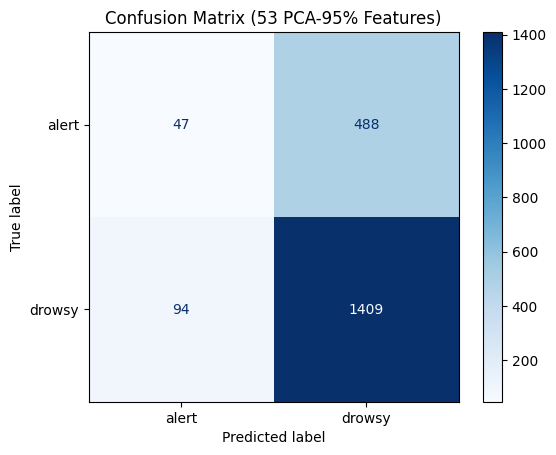

In [8]:
# === PREDICT ===
y_pred = rf_model.predict(X_test_sel)
y_proba = rf_model.predict_proba(X_test_sel)

# === CLASSIFICATION REPORT ===
print("\n📊 Random Forest (53 Selected Features):")
print(classification_report(
    y_test_enc,
    y_pred,
    target_names=le.classes_
))

# === F1 SCORES ===
print("F1 Macro:", f1_score(y_test_enc, y_pred, average='macro'))
print("F1 Weighted:", f1_score(y_test_enc, y_pred, average='weighted'))

# === ROC-AUC ===
auc = roc_auc_score(y_test_enc, y_proba[:, 1])
print("ROC-AUC:", auc)

# === CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_predictions(
    y_test_enc, y_pred,
    display_labels=le.classes_,
    cmap='Blues'
)
plt.title("Confusion Matrix (53 PCA-95% Features)")
plt.show()